In [1]:
from __future__ import print_function
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
# from cnn import ConvNet 
import argparse
import numpy as np     
import matplotlib.pyplot as plt
from cProfile import label
import json
import sys
# import pandas as pd

In [65]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self, mode, image_size, num_classes):
        super(ConvNet, self).__init__()
        
        self.mode = mode
        # Define various layers here, such as in the tutorial example
        # self.conv1 = nn.Conv2D(...)
        # Pool over 2x2 regions, 40 kernels, stride =1, with kernel size of 5x5.
        # define first conv laver 
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=32,
            kernel_size=(3, 3),
            padding=(1, 1),
        )
        
        # define second conv layer
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=(3, 3),
            padding=(1, 1),
        )

        # define third conv layer
        self.conv3 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=(3, 3),
            padding=(1, 1),
        )

        # define forth conv layer
        self.conv4 = nn.Conv2d(
            in_channels=64,
            out_channels=64,
            kernel_size=(3, 3),
            padding=(1, 1),
        )
        # define fifth conv layer
        self.conv5 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=(3, 3),
            padding=(1, 1),
        )
        # define last conv layer
        self.conv6 = nn.Conv2d(
            in_channels=128,
            out_channels=128,
            kernel_size=(3, 3),
            padding=(1, 1),
        )
        

        # define pool layer
        self.pool = nn.MaxPool2d(2) #kernel_size=(2, 2), stride=(1, 1))
        
        if mode == 1:
            fc_input_size = 4 * 4 * 64
        elif mode == 2:
            fc_input_size = 2 * 2 * 128
        self.batchnorm = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(fc_input_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.Softmax(dim=-1)
        
        
        self.forward = self.model
        
    # Use two convolutional layers.
    def model(self, X):
        # Three convolutional layers 
        X = F.relu(self.conv1(X))
        X = self.pool(X)
        X = F.relu(self.conv2(X))
        X = self.pool(X)
        # X = self.dropout(X)
        X = F.relu(self.conv3(X))
        # Adding more conv layers
        # X = F.relu(self.conv4(X))
        X = self.pool(X)
        # X = self.dropout(X)
        # X = F.relu(self.conv5(X))
        # X = F.relu(self.conv6(X))
        # X = self.pool(X)
        # X = self.dropout(X)
        if self.mode == 2:
            # for _ in range(2):
            X = F.relu(self.conv4(X))
            X = self.dropout(X)
            X = self.pool(X)
            X = F.relu(self.conv5(X))
            X = self.batchnorm(X)
            # X = self.pool(X)
        
        # two fully connected layers, with ReLU. and  + Dropout.
        X = X.reshape(X.shape[0], -1)
        X = F.relu(self.fc1(X))
        # X = self.dropout(X)
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return X

    


In [54]:
# Check if cuda is available
use_cuda = torch.cuda.is_available()

# Set proper device based on cuda availability 
device = torch.device("cuda" if use_cuda else "cpu")
print("Torch device selected: ", device)

# Create transformations to apply to each data sample 
# Can specify variations such as image flip, color flip, random crop, ...
# transform=transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
#     ])
transform = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.0,), (1.0,))
        ])

# Load datasets for training and testing
# Inbuilt datasets available in torchvision (check documentation online)
dataset1 = datasets.CIFAR10('./data/', train=True, download=True,
                    transform=transform)
dataset2 = datasets.CIFAR10('./data/', train=False,
                    transform=transform)

Torch device selected:  cuda
Files already downloaded and verified


In [55]:
def load_data(batch_size=10, num_workers=4):
    train_loader = DataLoader(dataset1, batch_size = batch_size, 
                            shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset2, batch_size = batch_size, 
                                shuffle=False, num_workers=4)
    
    return train_loader, test_loader

def plot(num_epochs, losses, accuracies, best_accuracy, save=0, mode=1):
    x = range(1, num_epochs+1)

    train_accuracies, test_accuracies = accuracies[0], accuracies[1]
    train_losses, test_losses = losses[0], losses[1]
    ## accuracies plot
    plt.title(f'Model {mode} Accuracies')
    plt.plot(x, train_accuracies, 'r')
    plt.plot(x, test_accuracies, 'b')
    plt.legend(['Train Accuracy', 'Test Accuracy'])

    if save:
        plt.savefig(f'plots/model_{mode}_accuracies.jpg')
        plt.show()

    ## losses plot
    plt.title(f'Model {mode} Losses')
    plt.plot(x, train_losses, 'r')
    plt.plot(x, test_losses, 'b')
    plt.legend(['Train Losses', 'Test Losses'])

    if save:
        plt.savefig(f'plots/model_{mode}_losses.jpg')
        plt.show()

def train(model, device, train_loader, optimizer, criterion, epoch, batch_size, num_epochs):
    '''
    Trains the model for an epoch and optimizes it.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    train_loader: dataloader for training samples.
    optimizer: optimizer to use for model parameter updates.
    criterion: used to compute loss for prediction and target 
    epoch: Current epoch to train for.
    batch_size: Batch size to be used.
    '''
    
    # Set model to train mode before each epoch
    model.train()
    
    # Empty list to store losses 
    losses = []
    correct = 0
    # Iterate over entire training samples (1 epoch)
    for batch_idx, batch_sample in enumerate(train_loader):
        # if batch_idx == 3:
        #     break
        data, target = batch_sample
        # print(f'{data.shape = }')
        
        # Push data/label to correct device
        data, target = data.to(device), target.to(device)
        
        # Reset optimizer gradients. Avoids grad accumulation (accumulation used in RNN).
        optimizer.zero_grad()
        
        # Do forward pass for current set of data
        output = model(data)
        # print(output.detach().numpy())
        # Compute loss based on criterion
        loss = criterion(output, target)
        
        # Computes gradient based on final loss
        loss.backward()
        
        # Store loss
        losses.append(loss.item())
        
        # Optimize model parameters based on learning rate and gradient 
        optimizer.step()
        
        # Get predicted index by selecting maximum log-probability
        pred = output.argmax(dim=1, keepdim=True)
        
        _, predictions = output.max(1)
        correct += (predictions == target).sum()
        print(f'Training epoch: ({epoch}/{num_epochs}) batch: ({batch_idx+1}/{len(train_loader)})', end='\r') #. Acc: {correct}/{(batch_idx+1) * batch_size}, {100. * correct / ((batch_idx+1) * batch_size)}', end='\r')
        
    train_loss = float(np.mean(losses))
    train_acc = 100. * (correct / ((batch_idx+1) * batch_size))
    print('\nTrain set ({}/{}): Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch, num_epochs,
        float(np.mean(losses)), correct, (batch_idx+1) * batch_size, train_acc))
    return train_loss, train_acc
    
def test(model, device, test_loader, criterion, epoch, num_epochs, batch_size):
    '''
    Tests the model.
    model: The model to train. Should already be in correct device.
    device: 'cuda' or 'cpu'.
    test_loader: dataloader for test samples.
    '''
    
    # Set model to eval mode to notify all layers.
    model.eval()
    
    losses = []
    correct = 0
    
    # Set torch.no_grad() to disable gradient computation and backpropagation
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)
            # Predict for data by doing forward pass
            output = model(data)
        
            # Compute loss based on same criterion as training 
            loss = criterion(output, target)
            
            # Append loss to overall test loss
            losses.append(loss.item())
            
            # Get predicted index by selecting maximum log-probability
            pred = output.argmax(dim=1, keepdim=True)
            
            _, predictions = output.max(1)
            correct += (predictions == target).sum()
            print(f'Testing epoch: ({epoch}/{num_epochs}) batch: ({batch_idx+1}/{len(test_loader)})', end='\r')

    test_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set ({}/{}): Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch, num_epochs,
        test_loss, correct, len(test_loader.dataset), accuracy))
    
    return test_loss, accuracy


In [56]:
def run_model(mode=1, learning_rate=0.01, batch_size=10, num_epochs=60):
    image_size = 32*32*3
    num_classes = 10

    # Initialize the model and send to device 
    model = ConvNet(mode, image_size, num_classes).to(device)
    # Define loss function.
    criterion = nn.CrossEntropyLoss()
    # Define optimizer function.
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Define data loaders
    train_loader, test_loader = load_data(batch_size)

    best_accuracy = 0.0

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    # Run training for n_epochs specified in config 
    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = train(model, device, train_loader,
                                            optimizer, criterion, epoch, batch_size, num_epochs)
        test_loss, test_accuracy = test(model, device, test_loader, criterion, epoch, num_epochs, batch_size)
        
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        # print(train_accuracy.cpu().numpy())
        train_accuracies.append(train_accuracy.cpu().numpy())
        test_accuracies.append(test_accuracy.cpu().numpy())

    accuracies = [train_accuracies, test_accuracies]
    losses = [train_losses, test_losses]
    plot(num_epochs, losses, accuracies, best_accuracy, save=1, mode=mode)

    print("Accuracy: {:2.2f}%".format(best_accuracy))

    print("Training and evaluation finished")



================================ Training model 1 ================================
CNN architecture which has more than 2 conv layers (3) and more than 1 fully connected layers (2)

learning_rate = 0.001
batch_size = 32
num_epochs = 30



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Train set (1/30): Average loss: 1.5379, Accuracy: 21628/50016 (43%)

Testing epoch: (1/30) batch: (313/313)
Test set (1/30): Average loss: 1.2788, Accuracy: 5323/10000 (53%)


Train set (2/30): Average loss: 1.1193, Accuracy: 30042/50016 (60%)


Test set (2/30): Average loss: 1.0178, Accuracy: 6408/10000 (64%)


Train set (3/30): Average loss: 0.9321, Accuracy: 33636/50016 (67%)


Test set (3/30): Average loss: 0.9323, Accuracy: 6766/10000 (68%)

Training epoch: (4/30) batch: (1563/1563)
Train set (4/30): Average loss: 0.8253, Accuracy: 35450/50016 (71%)

Testing epoch: (4/30) batch: (313/313)
Test set (4/30): Average loss: 0.8880, Accuracy: 6971/10000 (70%)


Train set (5/30): Average loss: 0.7520, Accuracy: 36795/50016 (74%)


Test set (5/30): Average loss: 0.8704, Accuracy: 6931/10000 (69%)

Training epoch: (6/30) batch: (1563/1563)
Train set (6/30): Average loss: 0.6973, Accuracy: 37685/50016 (75%)

Testing epoch: (6/30) batch: (313/313)
Test set (6/30): Average loss: 0.8458, Accu

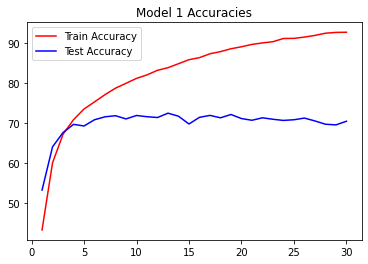

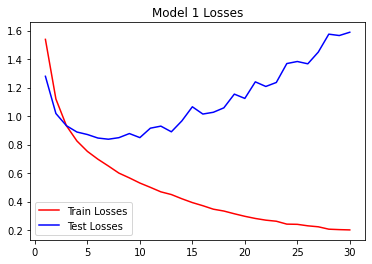

Accuracy: 72.52%
Training and evaluation finished


In [57]:
# ================== Model 1 ==================
learning_rate = 0.001
batch_size = 32
num_epochs = 30

print('\n\n'+('='*32)+' Training model 1 '+('='*32))
print('CNN architecture which has more than 2 conv layers (3) and more than 1 fully connected layers (2)')
print('\nlearning_rate = {}\nbatch_size = {}\nnum_epochs = {}\n'.format(learning_rate, batch_size, num_epochs))
run_model(mode=1, learning_rate=learning_rate, batch_size=batch_size, num_epochs=num_epochs)    
# print('='*80)

================================ Training model 2 ================================
Increase the number of conv layers (5) in the above network and train again.

learning_rate = 0.001
batch_size = 32
num_epochs = 30


Train set (1/30): Average loss: 1.6147, Accuracy: 19779/50016 (40%)


Test set (1/30): Average loss: 1.4061, Accuracy: 5014/10000 (50%)


Train set (2/30): Average loss: 1.2482, Accuracy: 27203/50016 (54%)


Test set (2/30): Average loss: 1.3600, Accuracy: 5281/10000 (53%)

Training epoch: (3/30) batch: (1563/1563)
Train set (3/30): Average loss: 1.0985, Accuracy: 30218/50016 (60%)

Testing epoch: (3/30) batch: (313/313)
Test set (3/30): Average loss: 1.2398, Accuracy: 5610/10000 (56%)


Train set (4/30): Average loss: 1.0012, Accuracy: 32208/50016 (64%)

Testing epoch: (4/30) batch: (313/313)
Test set (4/30): Average loss: 1.0140, Accuracy: 6474/10000 (65%)

Training epoch: (5/30) batch: (1563/1563)
Train set (5/30): Average loss: 0.9341, Accuracy: 33473/50016 (67%)

Test

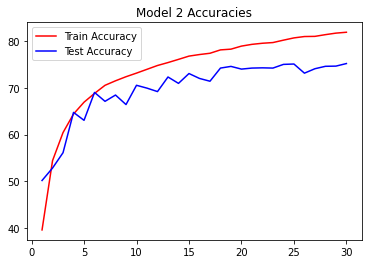

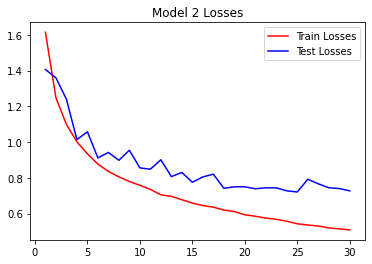

Accuracy: 75.21%
Training and evaluation finished


In [66]:
# ================== Model 2 ==================
learning_rate = 0.001
batch_size = 32
num_epochs = 30

print(('='*32)+' Training model 2 '+('='*32))
print('Increase the number of conv layers (5) in the above network and train again.')
print('\nlearning_rate = {}\nbatch_size = {}\nnum_epochs = {}\n'.format(learning_rate, batch_size, num_epochs))

run_model(mode=2, learning_rate=learning_rate, batch_size=batch_size, num_epochs=num_epochs)
print('='*80)